In [1]:
from pyoxigraph import *
from RDF import RDF
from OWL import OWL
from RDFS import RDFS
from utils import *
from Ressources import *
from Ontology import *

/home/sam/github/EmbedAlign/embed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.cuda.is_available()
print(device)

True


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Example: embeddings tensor (N_samples x D)
# embeddings = torch.randn(50, 768, device='cuda')  # optionally on GPU



def plot_region(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(cov_2d, n_std)
    ellipse = Ellipse(
        xy=mu_2d.cpu().numpy(),
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor='lightblue',
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0].cpu().numpy(), mu_2d[1].cpu().numpy(), c='red', s=30)
    if label:
        ax.text(mu_2d[0].cpu().numpy(), mu_2d[1].cpu().numpy(), f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

In [5]:
file = "../test/bfo-core.ttl"
bfo = Ontology.load(file)

label:  temporal instant, sentences : ['temporal instant has no subclasses', 'temporal instant is a subclass of temporal instant', 'an annotation for temporal instant is http://www.w3.org/2004/02/skos/core#example', 'an annotation for temporal instant is The millennium']


ValueError: inf error again at temporal instant

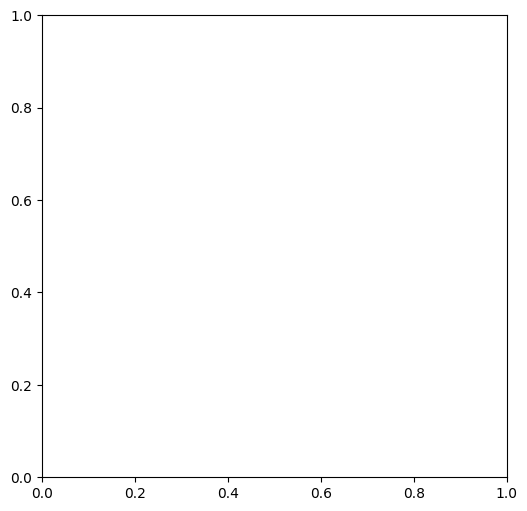

In [6]:

figs, axs = plt.subplots(figsize=(6,6))
for c in bfo.named_classes:
    center, cov = c.get_initial_region()
    plot_region(center, cov, label=str(c), n_std=2.0, ax=axs)
plt.plot()

In [3]:
word_1 = "bank"
sentences = ["I have 200 dollars in my bank account", 
            "My bank is on 35th street", 
            "I took out a lone at my bank",
            "my bank is closed on weekends"]
sentences_2 = ["the ship is at the river bank", 
            "the river bank is muddy", 
            "I like sitting at bank of the river",
            "the river bank can not close"]

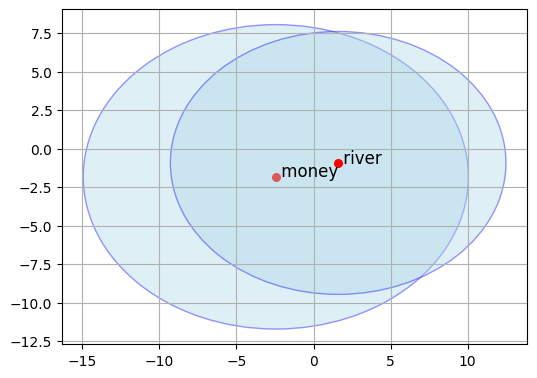

In [4]:
mu_2d, cov_2d = get_center_and_cov(word_1, sentences)
mu_2d_2, cov_2d_2 = get_center_and_cov(word_1, sentences_2)
# 4. Plot
fig, ax = plt.subplots(figsize=(6,6))
plot_region(mu_2d, cov_2d, label="money", n_std=2.0, ax=ax)
plot_region(mu_2d_2, cov_2d_2, label="river", n_std=2.0, ax=ax)

plt.show()
